# Adversarial attacks on deep image classification models.

## Setting Up Environment and Dependencies

In [3]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms
# PyTorch Lightning
!pip install --quiet pytorch-lightning>=1.4
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial10"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

<ipython-input-3-351eacb2d099>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


We have again a few download statements. This includes both a dataset, and a few pretrained patches we will use later.

In [4]:
import urllib.request
from urllib.error import HTTPError
import zipfile
# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]
# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(file_path.rsplit("/",1)[0])

Unzipping file...
Unzipping file...


## Deep CNNs on ImageNet

Common CNN architectures trained on the ImageNet dataset. DenseNet201 is used here.

In [23]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.densenet201(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

In [24]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])
# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)
])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=8)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [25]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

Classification accuracy of DenseNet201 CNN model on the ImageNet data

In [26]:
_ = eval_model(data_loader)

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 13.92%
Top-5 error: 2.22%


In [27]:
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(12,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})

    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('Adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise)
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    print(topk_vals)
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

Let's visualize a few images below:

[9.9932468e-01 9.7928954e-05 9.2005306e-05 6.0666691e-05 6.0557613e-05]


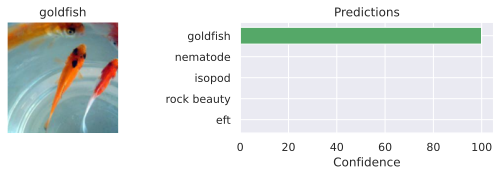

[0.5751872  0.27798936 0.13751946 0.00149397 0.0014805 ]


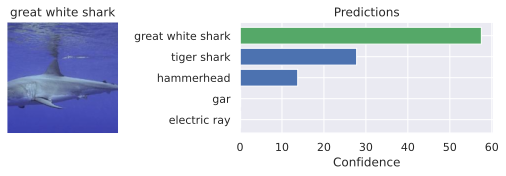

[0.9619726  0.01411711 0.01224836 0.00239105 0.00187484]


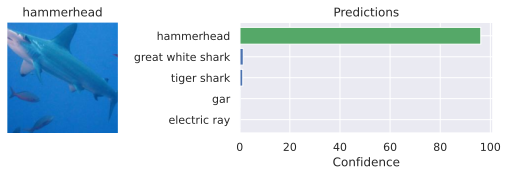

In [28]:
exmp_batch, label_batch = next(iter(data_loader))
with torch.no_grad():
    preds = pretrained_model(exmp_batch.to(device))
for i in [9,12,23]:      #(1,32,8) (3,6,13,18)
    show_prediction(exmp_batch[i], label_batch[i], preds[i])

## Implementing FGSM Attack

In [29]:
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.02):
    # Determine prediction of the model
    inp_imgs = imgs.clone().requires_grad_()
    preds = model(inp_imgs.to(device))
    preds = F.log_softmax(preds, dim=-1)
    # Calculate loss by NLL
    loss = -torch.gather(preds, 1, labels.to(device).unsqueeze(dim=-1))
    loss.sum().backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    fake_imgs = imgs + epsilon * noise_grad
    fake_imgs.detach_()
    return fake_imgs, noise_grad

[0.5710664  0.0653817  0.04139139 0.04015562 0.04003833]


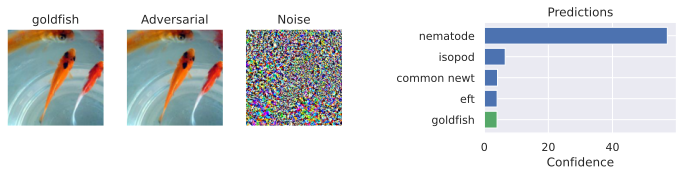

[0.5932467  0.375208   0.0157835  0.00319012 0.00155018]


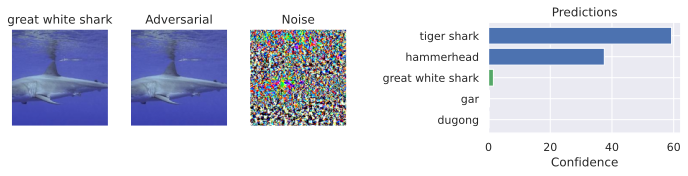

[0.31621173 0.22305594 0.13478486 0.05585776 0.03244738]


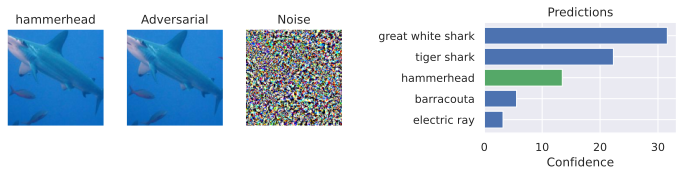

In [30]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.01)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.5708916  0.0487401  0.03533453 0.03381522 0.03372797]


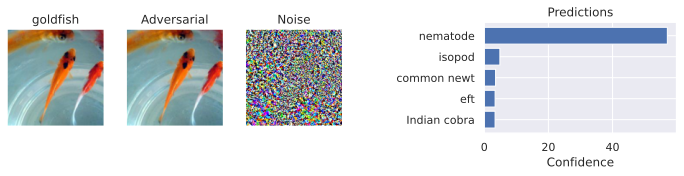

[0.65459824 0.31742057 0.00859415 0.0033824  0.00284354]


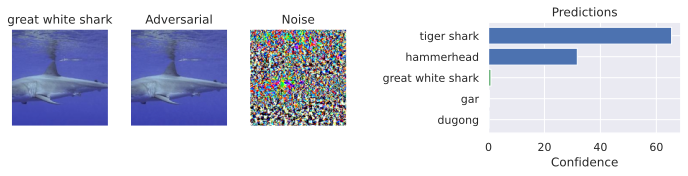

[0.38529226 0.24882151 0.06019073 0.04504787 0.02503061]


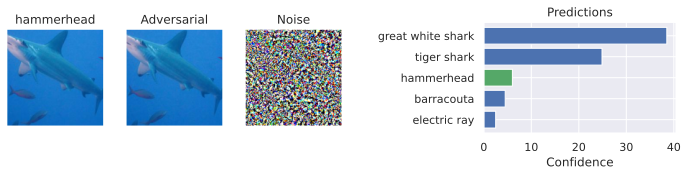

In [31]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.02)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.71027106 0.03241675 0.02596323 0.01365047 0.01359892]


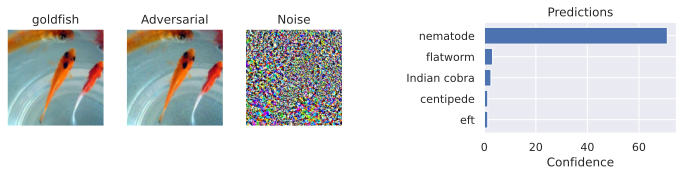

[0.66158956 0.26853767 0.01764517 0.00760952 0.00480966]


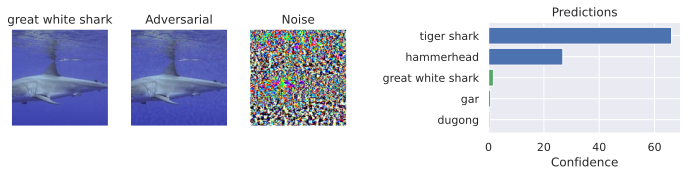

[0.5101671  0.3333636  0.0291686  0.01396268 0.00861707]


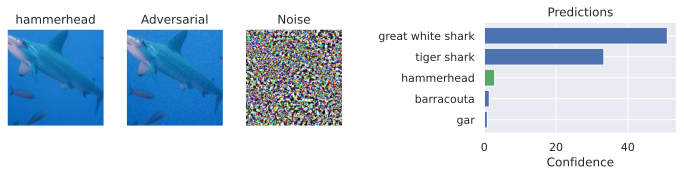

In [32]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.08)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

[0.76347566 0.0270735  0.01784022 0.01099682 0.01086533]


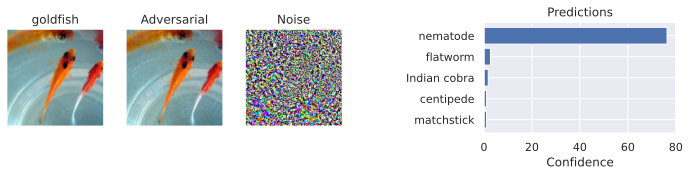

[0.6385691  0.2651645  0.02457145 0.01423066 0.00543526]


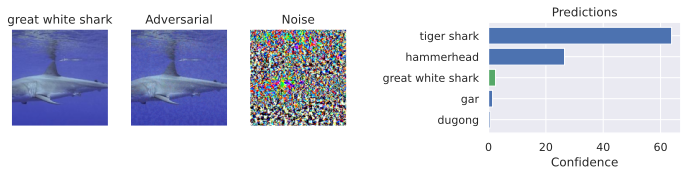

[0.53536606 0.30661386 0.03230754 0.01841049 0.01044385]


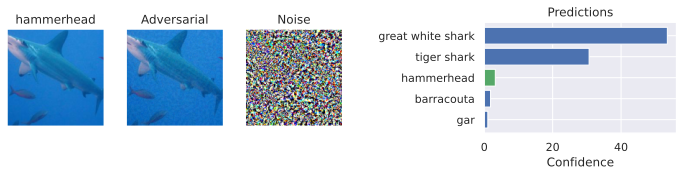

In [33]:
adv_imgs, noise_grad = fast_gradient_sign_method(pretrained_model, exmp_batch, label_batch, epsilon=0.10)
with torch.no_grad():
    adv_preds = pretrained_model(adv_imgs.to(device))

for i in [9,12,23]:   #(1,32,8)
    show_prediction(exmp_batch[i], label_batch[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])

In [36]:
import pandas as pd

# Define the list of epsilon values
epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Initialize lists to store results
top1_errors = []
top5_errors = []

# Evaluate the model for each epsilon value and store the results
for epsilon in epsilons:
    result = eval_model(data_loader, img_func=lambda x, y: fast_gradient_sign_method(pretrained_model, x, y, epsilon=epsilon)[0])
    top1_errors.append(100*(1-result[0]))
    top5_errors.append(100*(1-result[1]))

Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Top-1 error: 78.94%
Top-5 error: 34.62%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 89.92%
Top-5 error: 52.28%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 93.08%
Top-5 error: 59.90%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.22%
Top-5 error: 63.96%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.48%
Top-5 error: 66.22%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.66%
Top-5 error: 67.48%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.64%
Top-5 error: 67.74%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.36%
Top-5 error: 67.82%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.34%
Top-5 error: 67.94%


Validating...:   0%|          | 0/157 [00:00<?, ?it/s]

Top-1 error: 94.12%
Top-5 error: 67.86%


In [44]:
# Create DataFrame
df = pd.DataFrame({
    'Epsilon': epsilons,
    'Top-1 Error': top1_errors,
    'Top-5 Error': top5_errors
})

# Print DataFrame
print(' Performance of DenseNet161 under FGSM attack for different values of ε ')
print('_______________________________________________________________________')
print('                                                                                    ')
print(df)

 Performance of DenseNet161 under FGSM attack for different values of ε 
_______________________________________________________________________
                                                                                    
   Epsilon  Top-1 Error  Top-5 Error
0     0.01        78.94        34.62
1     0.02        89.92        52.28
2     0.03        93.08        59.90
3     0.04        94.22        63.96
4     0.05        94.48        66.22
5     0.06        94.66        67.48
6     0.07        94.64        67.74
7     0.08        94.36        67.82
8     0.09        94.34        67.94
9     0.10        94.12        67.86


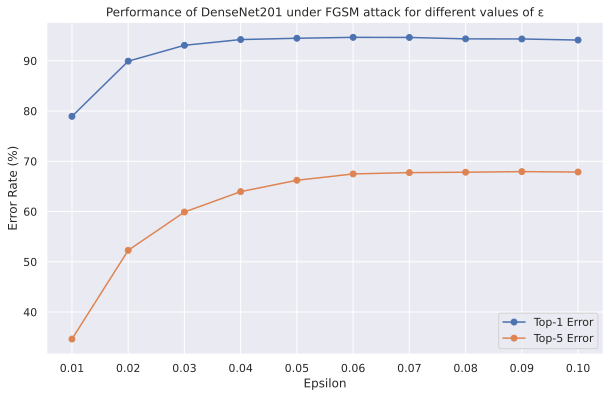

In [40]:
# Plot
plt.figure(figsize=(10, 6))

plt.plot(df['Epsilon'], df['Top-1 Error'], marker='o', label='Top-1 Error')
plt.plot(df['Epsilon'], df['Top-5 Error'], marker='o', label='Top-5 Error')

# Add labels and title
plt.title(' Performance of DenseNet201 under FGSM attack for different values of ε ')
plt.xlabel('Epsilon')
plt.ylabel('Error Rate (%)')
plt.xticks(df['Epsilon'])
plt.grid(True)
plt.legend()

# Show plot
plt.show()

 **Outcome:**

 **Before FGSM attack:** The baseline accuracy of DenseNet201 is established (Top-1 error at 13.92% and Top-5 error at 2.22%).

 **After FGSM attack:** The attack is successful. Also there is a decrease in accuracy(i.e., the classification error increases) as epsilon values for FGSM attack is increased from 0.01 to 0.1.

The impact of the FGSM attack is so severe that the classification error for the DenseNet201 model in the presence of this attack reaches as high values as 94.66% (Top-1 error) and 67.94% (Top-5 error).